<a href="https://colab.research.google.com/github/akshan-main/clothedit/blob/main/clothedit1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q diffusers transformers accelerate scipy

In [ ]:
!pip install -q -U xformers
!pip install -q opencv-python

In [ ]:
!pip install -q git+https://github.com/facebookresearch/segment-anything.git


  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q regex tqdm

In [ ]:
!pip install -q pycocotools matplotlib onnxruntime onnx

In [ ]:
import torch

from torchvision import transforms
from torchvision.transforms.functional import to_pil_image, to_tensor

import PIL, cv2
from PIL import Image

from io import BytesIO
from IPython.display import display
import base64, json, requests
from matplotlib import pyplot as plt

import numpy as np
import copy

from numpy import asarray

import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-12-07 09:25:17--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.111, 13.226.210.25, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  17.7MB/s    in 29s     

2023-12-07 09:25:46 (83.3 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



In [ ]:
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

model_dir="stabilityai/stable-diffusion-2-inpainting"

scheduler = EulerDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")

pipe = StableDiffusionInpaintPipeline.from_pretrained(model_dir,
                                                   scheduler=scheduler,
                                                   revision="fp16",
                                                   torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()


/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
text_encoder/model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Source image size: (800, 1000)
Target image size: (512, 512)


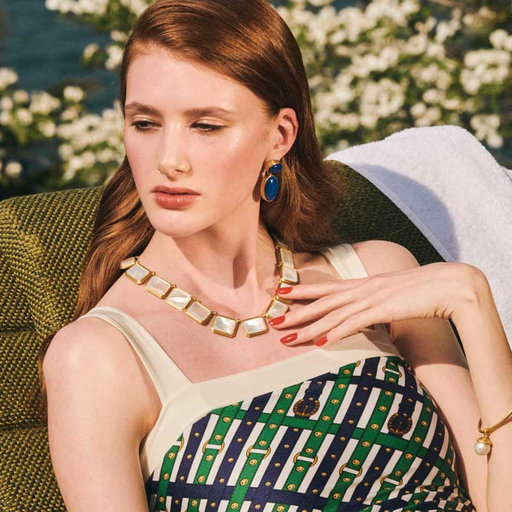

In [ ]:
target_width, target_height = 512,512
source_image = Image.open('image-1.jpg')

width, height = source_image.size
print(f"Source image size: {source_image.size}")


source_image = source_image.crop((0, height-width , width , height))


source_image = source_image.resize((target_width, target_height), Image.LANCZOS )
print(f"Target image size: {source_image.size}")

segmentation_image = asarray(source_image)

display(source_image)



In [ ]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.99,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)


In [ ]:
masks = mask_generator.generate(segmentation_image)

print(f"Number of masks generated: {len(masks)}")
print(masks[0].keys())


Number of masks generated: 9
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return

    sorted_anns = sorted(enumerate(anns), key=(lambda x: x[1]['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for original_idx, ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))
        contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            cnt = contours[0]
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                ax.text(cx, cy, str(original_idx), color='white', fontsize=16, ha='center', va='center', fontweight='bold')

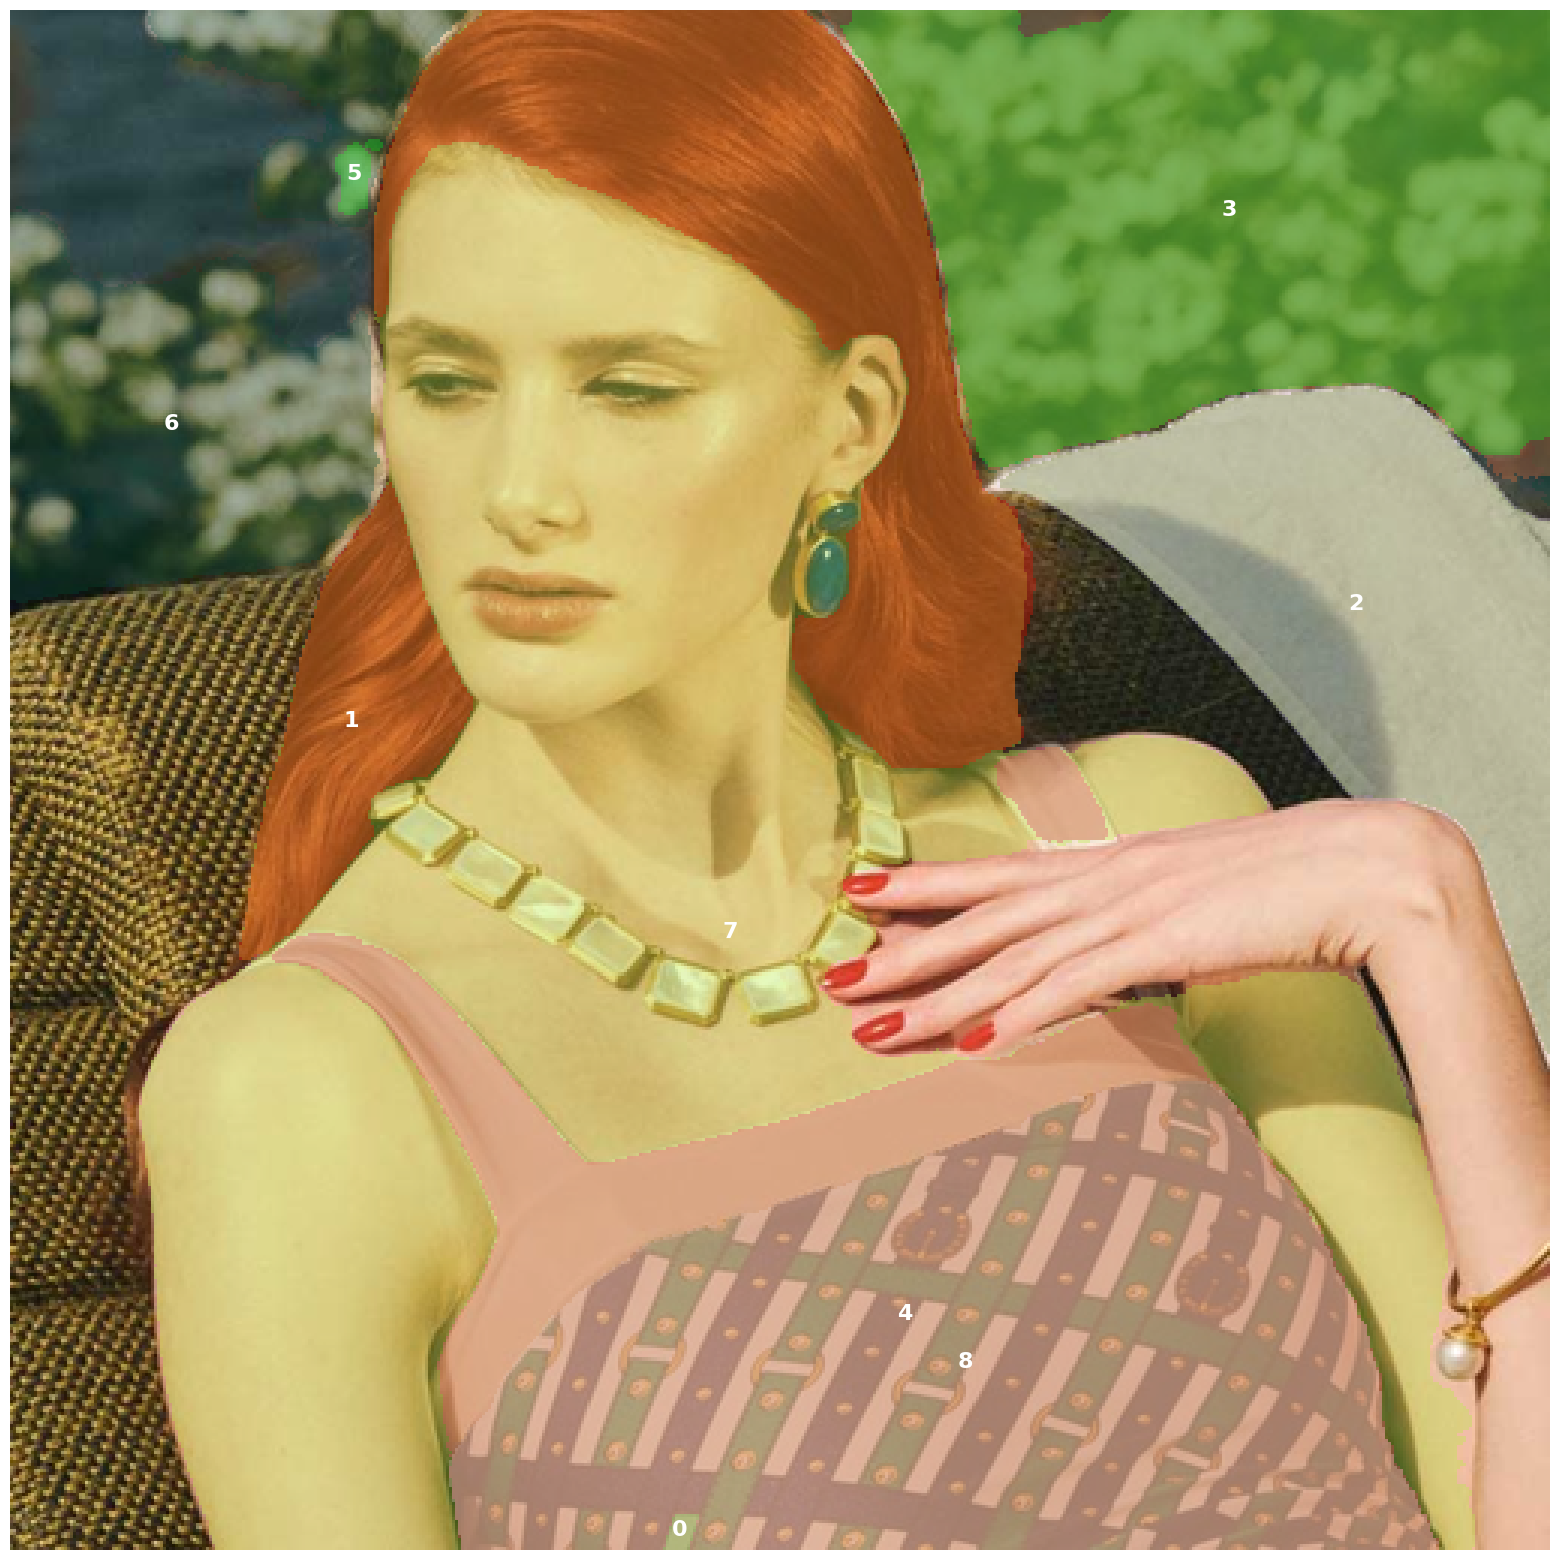

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(source_image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
for i, values in enumerate(masks):
   print(f"{i}: Area: {values['area']} | IoU: {values['predicted_iou']}")


0: Area: 102 | IoU: 0.991751492023468
1: Area: 24525 | IoU: 1.0106863975524902
2: Area: 16516 | IoU: 0.991471529006958
3: Area: 28939 | IoU: 1.0238702297210693
4: Area: 47501 | IoU: 1.0145643949508667
5: Area: 28690 | IoU: 0.9982881546020508
6: Area: 44063 | IoU: 0.994900107383728
7: Area: 145205 | IoU: 0.9945452213287354
8: Area: 36198 | IoU: 0.9907949566841125


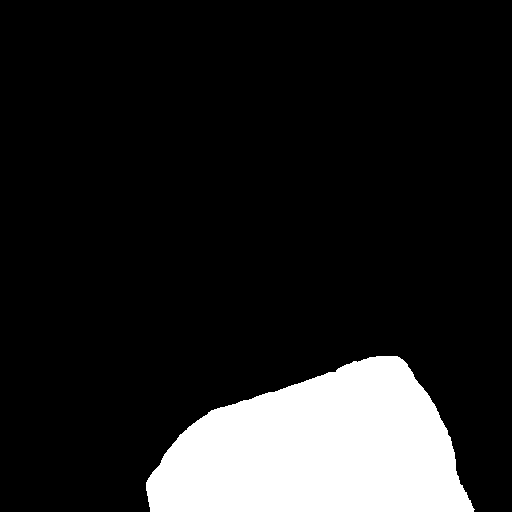

In [ ]:
mask_index = 8

segmentation_mask=masks[mask_index]['segmentation']
stable_diffusion_mask=PIL.Image.fromarray(segmentation_mask)
display(stable_diffusion_mask)

In [ ]:

num_images_per_prompt = 4
inpainting_prompts = ["tiger","disco","numbers","camo"]

generator = torch.Generator(device="cuda").manual_seed(99)

encoded_images = []
for i in range(num_images_per_prompt):
        image = pipe(prompt=inpainting_prompts[i], guidance_scale=7.5, num_inference_steps=60, generator=generator, image=source_image, mask_image=stable_diffusion_mask).images[0]
        encoded_images.append(image)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
def create_image_grid(original_image, images, names, rows, columns):
    names = copy.copy(names)
    images = copy.copy(images)
    if torch.is_tensor(images):
        assert images.size(0) == len(names), "Number of images and names should be equal"
        assert images.size(0) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"
        images = [to_pil_image(torch.sigmoid(img)) for img in images]
    else:
        assert len(images) == len(names), "Number of images and names should be equal"
    assert len(images) >= (rows * columns) - 1 - 1, "Not enough images for the specified grid size"
    images.insert(0, original_image)
    names.insert(0, '')

    fig, axes = plt.subplots(rows, columns, figsize=(15, 15))
    for idx, (img, name) in enumerate(zip(images, names)):
        row, col = divmod(idx, columns)
        axes[row, col].imshow(img, cmap='gray' if idx > 0 and torch.is_tensor(images) else None)
        axes[row, col].set_title(name)
        axes[row, col].axis('off')

    for idx in range(len(images), rows * columns):
        row, col = divmod(idx, columns)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

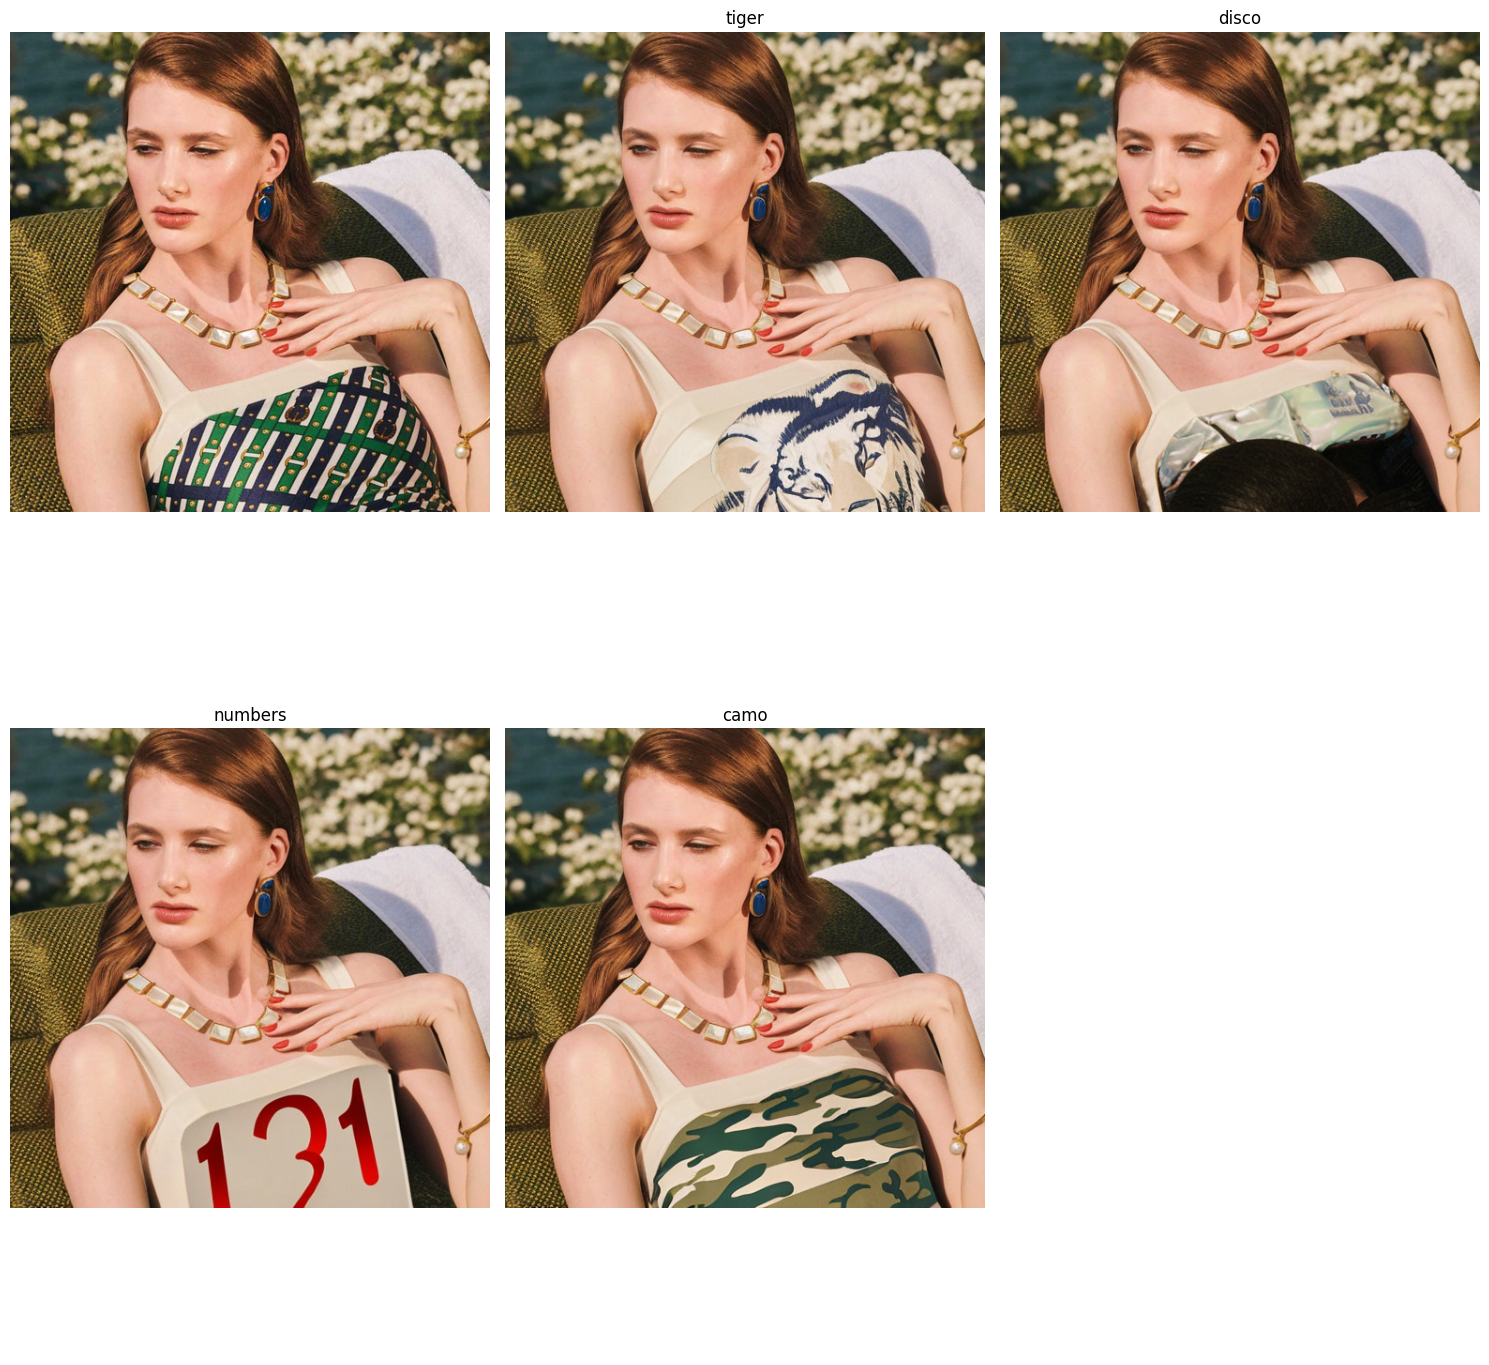

In [ ]:
create_image_grid(source_image, encoded_images, inpainting_prompts, 2, 3)